# Voorspellen van politieke partij op basis van tekst

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import pandas as pd
import time
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import DutchStemmer
import sqlite3
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

Inlezen SQL database

In [2]:
db = sqlite3.connect('reports.sqlite')

agenda_items = pd.read_sql_query("SELECT * FROM agenda_items", db)
speaker_items = pd.read_sql_query("SELECT * FROM speaker_turns", db)
speakers = pd.read_sql_query("SELECT * FROM speakers", db)

# controle of het inlezen goed gaat
agenda_items.head()
speaker_items.head()

id  agenda_item  turn_no  speaker  \
0   1            1        1        1   
1   2            5        1        2   
2   3            5        2        2   
3   4            5        3        3   
4   5            5        4        4   

                                                 txt  
0  Detijdelijke voorzitter:Ik deel aan de Kamer m...  
1  Voorzitter. Ik zal het idee van de heer Pechto...  
2  Zo mogelijk in aanwezigheid van de minister-pr...  
3  Ik kan mij die behoefte heel goed voorstellen....  
4  Steun namens D66 voor het verzoek van de heer ...

In [3]:
speaker_items

id  agenda_item  turn_no  speaker  \
0            1            1        1        1   
1            2            5        1        2   
2            3            5        2        2   
3            4            5        3        3   
4            5            5        4        4   
5            6            5        5        5   
6            7            5        6        6   
7            8            5        7        7   
8            9            5        8        2   
9           10            5        9        8   
10          11            5       10        9   
11          12            5       11       10   
12          13            5       12       11   
13          14            5       13       12   
14          15            5       14       13   
15          16            5       15       14   
16          17            5       16       12   
17          18            5       17       12   
18          19            5       18       15   
19          20            5       19       16   
20          21            5       20       17   
21          22            5       21       18   
22          23            5       22       19   
23          24            5       23       20   
24          25            5       24       21   
25          26            5       25       22   
26          27            5       26       23   
27          28            5       27       24   
28          29            5       28       25   
29          30            5       29       26   
...        ...          ...      ...      ...   
163937  163938         3507      162      135   
163938  163939         3507      163        1   
163939  163940         3507      164      135   
163940  163941         3507      165       68   
163941  163942         3507      166      135   
163942  163943         3507      167        1   
163943  163944         3507      168      135   
163944  163945         3507      169        1   
163945  163946         3507      170      135   
163946  163947         3507      171       68   
163947  163948         3507      172      135   
163948  163949         3507      173      135   
163949  163950         3507      174      135   
163950  163951         3507      175        1   
163951  163952         3507      176       46   
163952  163953         3507      177       46   
163953  163954         3507      178        1   
163954  163955         3507      179      127   
163955  163956         3507      180       74   
163956  163957         3507      181        1   
163957  163958         3507      182        1   
163958  163959         3507      183      207   
163959  163960         3507      184        1   
163960  163961         3507      185      135   
163961  163962         3507      186      207   
163962  163963         3507      187        1   
163963  163964         3507      188      135   
163964  163965         3507      189      207   
163965  163966         3507      190        1   
163966  163967         3507      191        1   

                                                      txt  
0       Detijdelijke voorzitter:Ik deel aan de Kamer m...  
1       Voorzitter. Ik zal het idee van de heer Pechto...  
2       Zo mogelijk in aanwezigheid van de minister-pr...  
3       Ik kan mij die behoefte heel goed voorstellen....  
4       Steun namens D66 voor het verzoek van de heer ...  
5       Als dit verzoek er ligt, kunnen wij niet ander...  
6                                   Steun van GroenLinks.  
7       Het Forum voor Democratie steunt dit verzoek v...  
8                       Nee, nee, die steun hoef ik niet.  
9                                                  Steun.  
10                     Steun van de PVV voor dit verzoek.  
11                        Steun namens de fractie 50PLUS.  
12                                   Namens de SGP steun.  
13                   Als het CDA dat per se wil, vooruit.  
14                          Steun namens de ChristenUnie.  
15           

Politieke partijen toevoegen aan personen wanneer deze bekend was
De personen die niet tot een politieke partij behoren zijn niet benoemd tot een politieke partij en deze zullen in de volgende stap (bij het mergen) vanzelf uit de dataset gehaald worden.

In [4]:
speakers.loc[speakers['id'] == 48,'political'] = 'VVD' # minister Rutte behoort tot de VVD
speakers.loc[speakers['id'] == 49,'political'] = 'CDA'# meneer van Dam behoort tot het CDA
speakers.loc[speakers['id'] == 51,'political'] = 'VVD' # minister Hennis-Plasschaert behoort bij de VVD
speakers.loc[speakers['id'] == 54,'political'] = 'PvdA' # staatssecretaris Dijksma behoort tot PvdA
speakers.loc[speakers['id'] == 56,'political'] = 'VVD' # staatssecretaris Wiebes behoort tot VVD
speakers.loc[speakers['id'] == 84,'political'] = 'VVD' # mevrouw Schippers behoort tot de VVD
speakers.loc[speakers['id'] == 94,'political'] = 'PvdA'# Staatssecretaris van Rijn behoort tot de PvdA
speakers.loc[speakers['id'] == 98,'political'] = 'PvdA'# minister Plasterk behoort tot de PvdA
speakers.loc[speakers['id'] == 106,'political'] = 'VVD' # minister Blok behoort tot de VVD
speakers.loc[speakers['id'] == 108,'political'] = 'PvdA' # minister Koenders behoort tot de PvdA
speakers.loc[speakers['id'] == 115,'political'] = 'PvdA' # minister Ploumen behoort tot de PvdA
speakers.loc[speakers['id'] == 118,'political'] = 'VVD' # minister Schultz van Haegen-Maas Geesteranus behoort tot de VVD
speakers.loc[speakers['id'] == 125,'political'] = 'PvdA' # minister Asscher behoort tot de PvdA
speakers.loc[speakers['id'] == 134,'political'] = 'PvdA' # straatssecretaris Kleijnsma behoort tot de PvdA
speakers.loc[speakers['id'] == 136,'political'] = 'PvdA' # minister Ploumen behoort tot de PvdA
speakers.loc[speakers['id'] == 140,'political'] = 'PvdA' # minister Dijsselbloem behoort tot de PvdA
speakers.loc[speakers['id'] == 141,'political'] = 'VVD' # staatssecretaris Dijkhoff behoort tot de VVD
speakers.loc[speakers['id'] == 148,'political'] = 'VVD' # minister Kamp behoort tot de VVD
speakers.loc[speakers['id'] == 149,'political'] = 'VVD' # staatssecretaris Dekker behoort tot de VVD
speakers.loc[speakers['id'] == 157,'political'] = 'PvdA' # minister Bussemaker behoort tot de PvdA
speakers.loc[speakers['id'] == 169,'political'] = 'SP' # mevrouw Leijten behoort tot de SP
speakers.loc[speakers['id'] == 180,'political'] = 'CU' # mevrouw Schouten behoort tot de CU
speakers.loc[speakers['id'] == 181,'political'] = 'VVD' # minister Bruins behoort tot de VVD
speakers.loc[speakers['id'] == 182,'political'] = 'CDA' # minister De Jonge behoort tot de CDA
speakers.loc[speakers['id'] == 183,'political'] = 'CDA' # minister Grapperhaus behoort tot de CDA
speakers.loc[speakers['id'] == 184,'political'] = 'D66' # minister Koolmees behoort tot de D66
speakers.loc[speakers['id'] == 185,'political'] = 'CDA' # minister Bijleveld behoort tot de CDA
speakers.loc[speakers['id'] == 186,'political'] = 'VVD' # minister Dekker behoort tot de VVD
speakers.loc[speakers['id'] == 189,'political'] = 'D66' # minister Kaag behoort tot de D66
speakers.loc[speakers['id'] == 190,'political'] = 'VVD' # minister Knops behoort tot de CDA
speakers.loc[speakers['id'] == 191,'political'] = 'VVD' # minister Zijlstra behoort tot de VVD
speakers.loc[speakers['id'] == 192,'political'] = 'CDA' # minister Hoekstra behoort tot de CDA
speakers.loc[speakers['id'] == 193,'political'] = 'D66' # Staatssecretaris Snel behoort tot de D66
speakers.loc[speakers['id'] == 194,'political'] = 'CU' # minister Slob behoort tot de CU
speakers.loc[speakers['id'] == 195,'political'] = 'VVD' # minister Wiebes behoort tot de VVD
speakers.loc[speakers['id'] == 197,'political'] = 'CDA' # staatssecretaris Keijzer behoort tot de CDA
speakers.loc[speakers['id'] == 198,'political'] = 'D66' # minister Ollogren behoort tot de D66
speakers.loc[speakers['id'] == 203,'political'] = 'VVD' # Staatssecretaris Visser behoort tot de VVD
speakers.loc[speakers['id'] == 204,'political'] = 'VVD' # Staatssecretaris Van Ark behoort tot de VVD
speakers.loc[speakers['id'] == 207,'political'] = 'D66' # Minister Van Engelshoven behoort tot de D66
speakers.loc[speakers['id'] == 210,'political'] = 'VVD' # Minister Van Nieuwenhuizen-Wijbenga behoort tot de VVD
speakers.loc[speakers['id'] == 211,'political'] = 'D66' # Staatssecretaris Van Veldhoven behoort tot de D66
speakers.loc[speakers['id'] == 212,'political'] = 'VVD' # Staatssecretaris Harbers behoort tot de VVD
speakers.loc[speakers['id'] == 213,'political'] = 'CU' # Staatssecretaris Blokhuis behoort tot de CU
speakers.loc[speakers['id'] == 217,'political'] = 'PvdD' # De heer Wassenberg behoort tot de PvdD
speakers.loc[speakers['id'] == 218,'political'] = 'VVD' # De heer Van Meenen behoort tot de D66
speakers.loc[speakers['id'] == 233,'political'] = 'CDA' # Minister Bijleveld-Schouten behoort tot de CDA
speakers.loc[speakers['id'] == 234,'political'] = 'D66' # Staatssecretaris Van Veldhoven-van der Meer behoort tot de D66

In [5]:
# controle van het aantal sprekers per politieke partij
speakers.groupby('political').count()

id  prefix  name
political                              
50PLUS                  5       5     5
CDA                    29      28    29
CU                      3       3     3
ChristenUnie            6       6     6
D66                    30      30    30
DENK                    3       3     3
EP/CDA                  1       1     1
EP/CU/SGP               1       1     1
EP/D66                  1       1     1
EP/GroenLinks           1       1     1
EP/PvdA                 1       1     1
EP/PvdD                 1       1     1
EP/SP                   1       1     1
EP/VVD                  1       1     1
Forum voor Democratie   2       2     2
FvD                     2       2     2
GroenLinks             17      17    17
PVV                    21      21    21
PvdA                   21      21    21
PvdD                    9       9     9
SGP                     4       4     4
SP                     17      17    17
VVD                    59      59    59

Hieronder hebben we de sprekerdataset en wat ze gezegd hebben samengevoegd. Alle tekst van personen die Iedereen die niet tot een politieke partij behoord is uit de datset gehaald. 

In [6]:
merged = speaker_items.merge(speakers, left_on='speaker', right_on='id')[['txt','political']]

In [7]:
# controle welke partijen er zijn met hoeveel tekst
merged.groupby('political').count()

txt
political                   
50PLUS                  3477
CDA                    14344
CU                      1863
ChristenUnie            3568
D66                    14947
DENK                    3773
EP/CDA                     3
EP/CU/SGP                  1
EP/D66                     1
EP/GroenLinks              1
EP/PvdA                    1
EP/PvdD                    1
EP/SP                      1
EP/VVD                     7
Forum voor Democratie     66
FvD                     2029
GroenLinks             10093
PVV                     8442
PvdA                    8535
PvdD                    4050
SGP                     2720
SP                     12083
VVD                    20777

Uit bovenstaande lijst blijkt dat er door mensen van het europees parlement maar weinig wordt gezegd. Omdat hier zo weinig tekst van beschikbaar is, willen we deze niet meenemen in ons model, en hebben we alle teksten Europese parlementariers uit de dataset verwijderd.

In [8]:
merged = merged[~merged['political'].isin(['EP/CDA', 'EP/CU/SGP', 'EP/D66', 
                                           'EP/GroenLinks', 'EP/PvdA', 'EP/PvdD',
                                           'EP/SP', 'EP/VVD'])]
merged = merged.dropna()
merged = merged.replace('Forum voor Democratie','FvD')
merged = merged.replace('ChristenUnie','CU')
print(merged.groupby('political').count())

              txt
political        
50PLUS       3477
CDA         14344
CU           5431
D66         14947
DENK         3773
FvD          2095
GroenLinks  10093
PVV          8442
PvdA         8535
PvdD         4050
SGP          2720
SP          12083
VVD         20777


In [9]:
# split data in train en test set
X = merged['txt']
Y = merged.political.astype('category').values.codes
Ys = merged['political']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [10]:
allSpeakingTurns = X.to_frame().join(Ys)
allSpeakingTurns = allSpeakingTurns.reset_index()[['txt' , 'political']]

VPL = allSpeakingTurns['txt'][allSpeakingTurns['political'] == '50PLUS']
CDA = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'CDA']
CU = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'CU']
D66 = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'D66']
DENK = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'DENK']
FvD = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'FvD']
GL = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'GroenLinks']
PVV = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'PVV']
PvdA = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'PvdA']
PvdD = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'PvdD']
SGP = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'SGP']
SP = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'SP']
VVD = allSpeakingTurns['txt'][allSpeakingTurns['political'] == 'VVD']

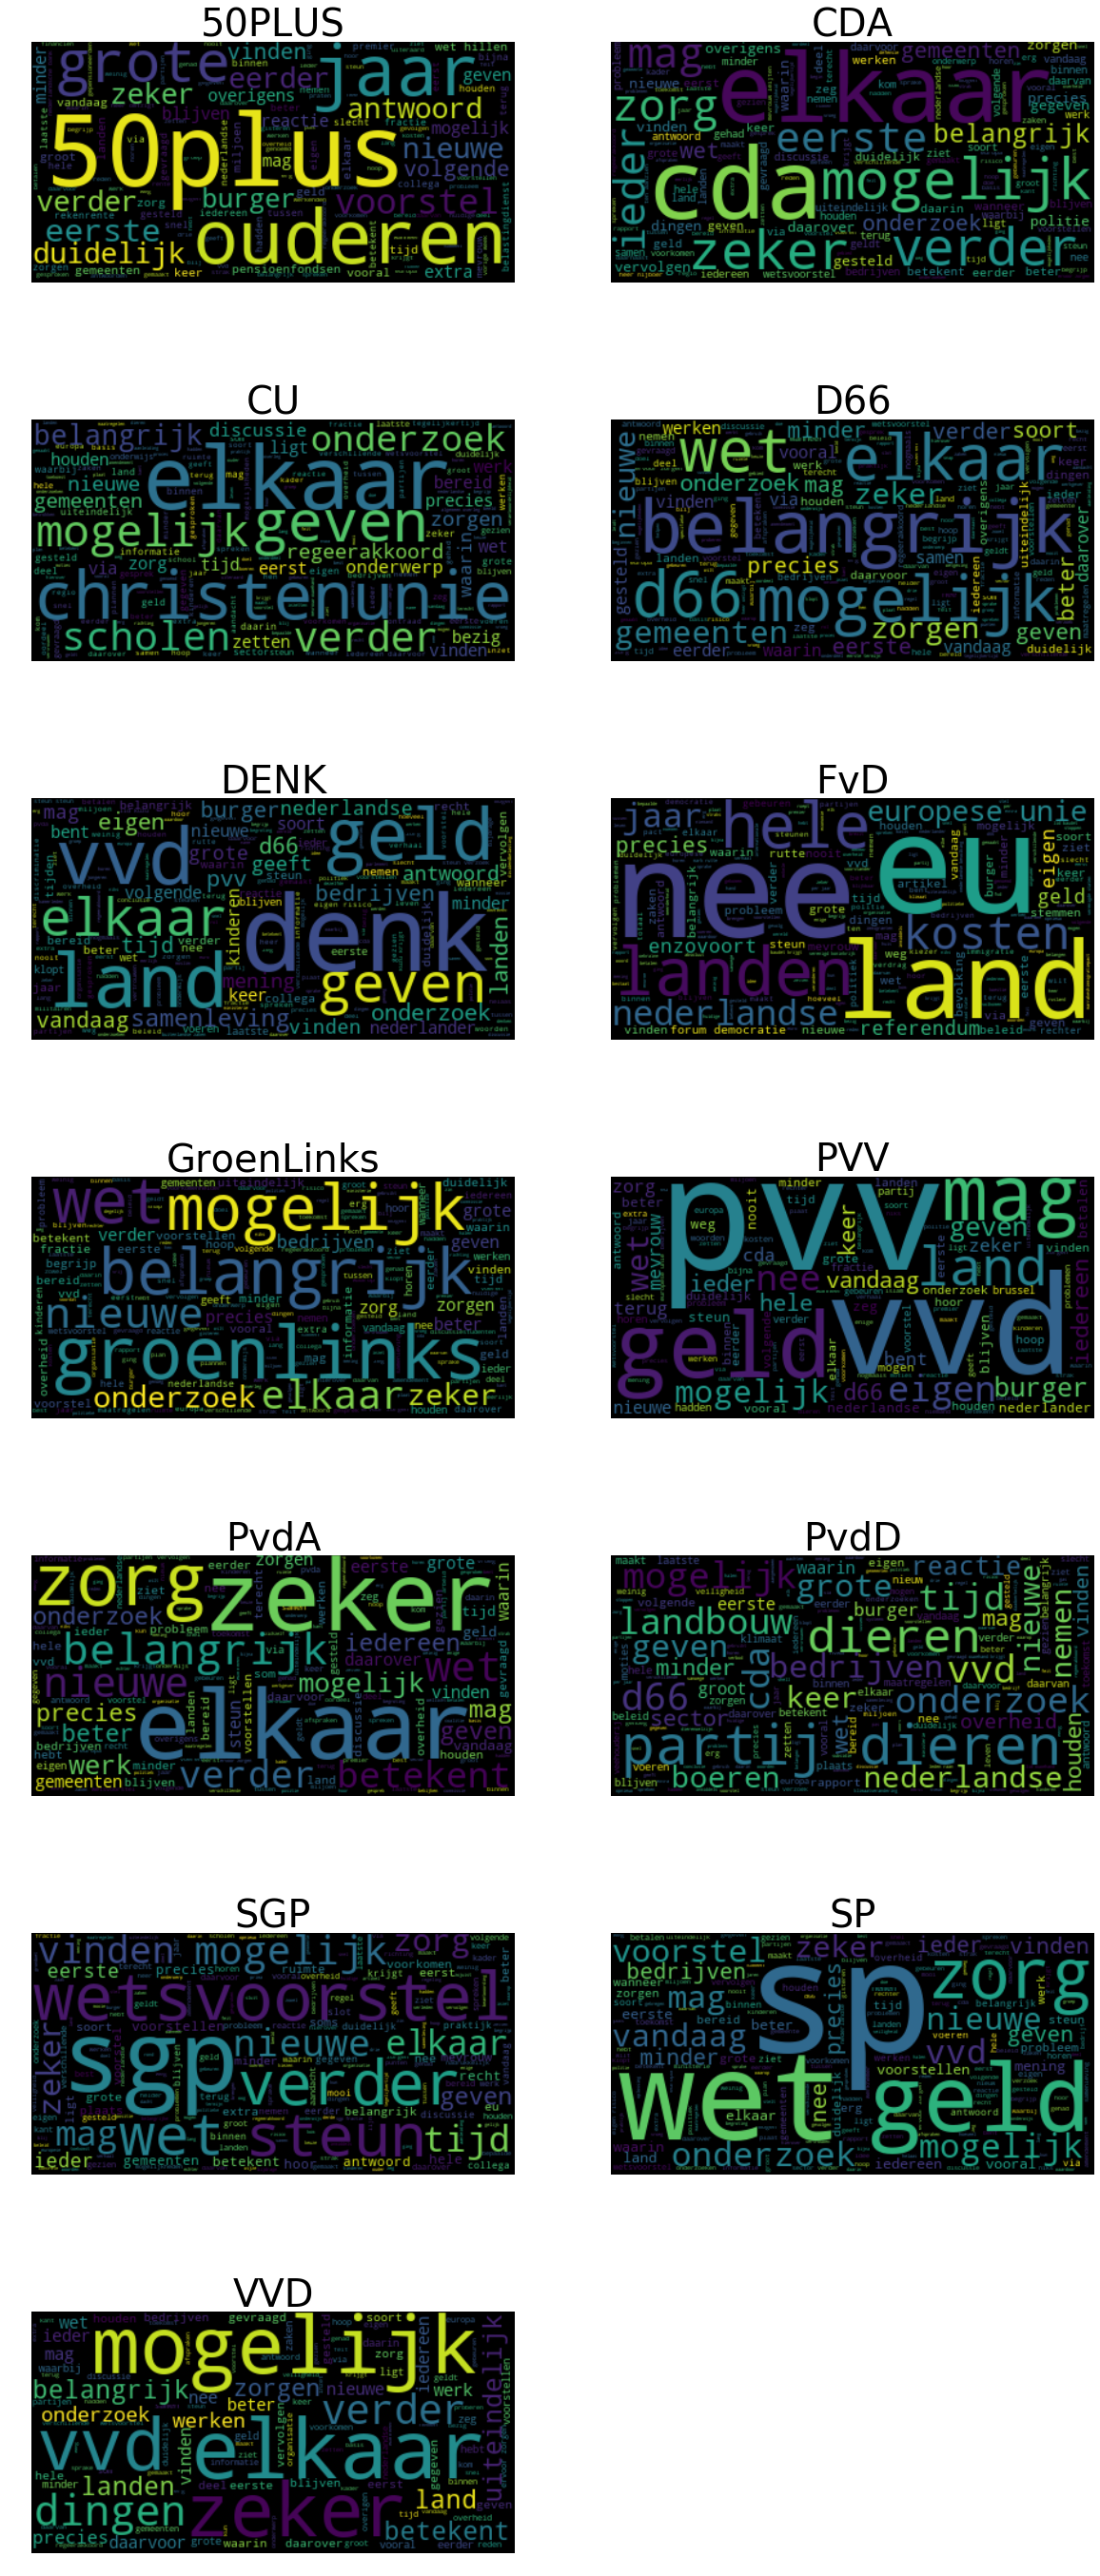

In [68]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from stop_words import get_stop_words
import nltk

stopwoorden = get_stop_words('dutch')
stopword_list = nltk.corpus.stopwords.words('dutch')
stopwoorden = stopwoorden + stopword_list
file = open('stopwoordenlijst.txt','r') 
for line in file: 
    stopwoorden.append(line) 
extras = ['we', 'wij','gaan','minister','gaat','wel','moeten','mensen','vraag',
          'nederland','voorzitter','waar','goed','kabinet','echt','willen','komen',
          'heel','zeggen','alleen', 'staatssecretaris', 'eigenlijk','zegt','komt',
          'vind','orde','dag','weer','motiede','maken','gehoorde beraadslaging',
         'zoals','namelijk','steeds','vragen','kijk','kijken','even','krijgen','zei',
         'gezegd','volgen','staat','waarom','president','miljard','kamer','zonder','ander',
         'moment','laten','zullen','volgen','volgens','inderdaad','overwegende','stuk','nr',
         'juist','net','verzoekt','regering','bijvoorbeeld','indiening ervan','nou','devoorzitter',
         'motie','beraadslaging constaterende','gehoord', 'beraadslaging','indiening ervan',
         'blijkt','indiening','voldoende ondersteund','ervan', 'voldoende','kunt','weet','ga',
         'constaterende','ondersteund','gewoon','natuurlijk','allemaal','alle','helemaal',
         'voorgesteld','mee','zodat','aangegeven','misschien','debat','zien','daarbij','gedaan',
         'weten','betreft','nodig','zouden','daarom','aantal','collega','af','belang','vaak',
         'zit','laat','graag','punt','vindt','zie','doet','onze','anders','geval','lijkt',
         'goede','toe','welke','allerlei','twee','situatie','vraagt','staan','zitten','terwijl',
         'brief','zeer','één','tweede','stellen','zo\'n','manier','beetje','blijft','daarmee',
         'dank','zelfs','vanuit','gebeurt']
for extra in extras:
    stopwoorden.append(extra)
    
plot = plt.figure(figsize=(20,50))

text = " ".join(spreekBeurt for spreekBeurt in VPL)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('50PLUS', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in CDA)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('CDA', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in CU)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('CU', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in D66)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,4)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('D66', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in DENK)
text = text.lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('DENK', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in FvD)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,6)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('FvD', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in GL)
text = text.replace('denk','').lower()

wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,7)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('GroenLinks', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PVV)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,8)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PVV', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PvdA)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,9)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PvdA', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PvdD)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,10)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PvdD', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in SGP)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,11)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('SGP', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in SP)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,12)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('SP', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in VVD)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,13)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('VVD', fontdict = {'fontsize': 40})

plt.show()

In [69]:
plot.savefig('graph3.png')

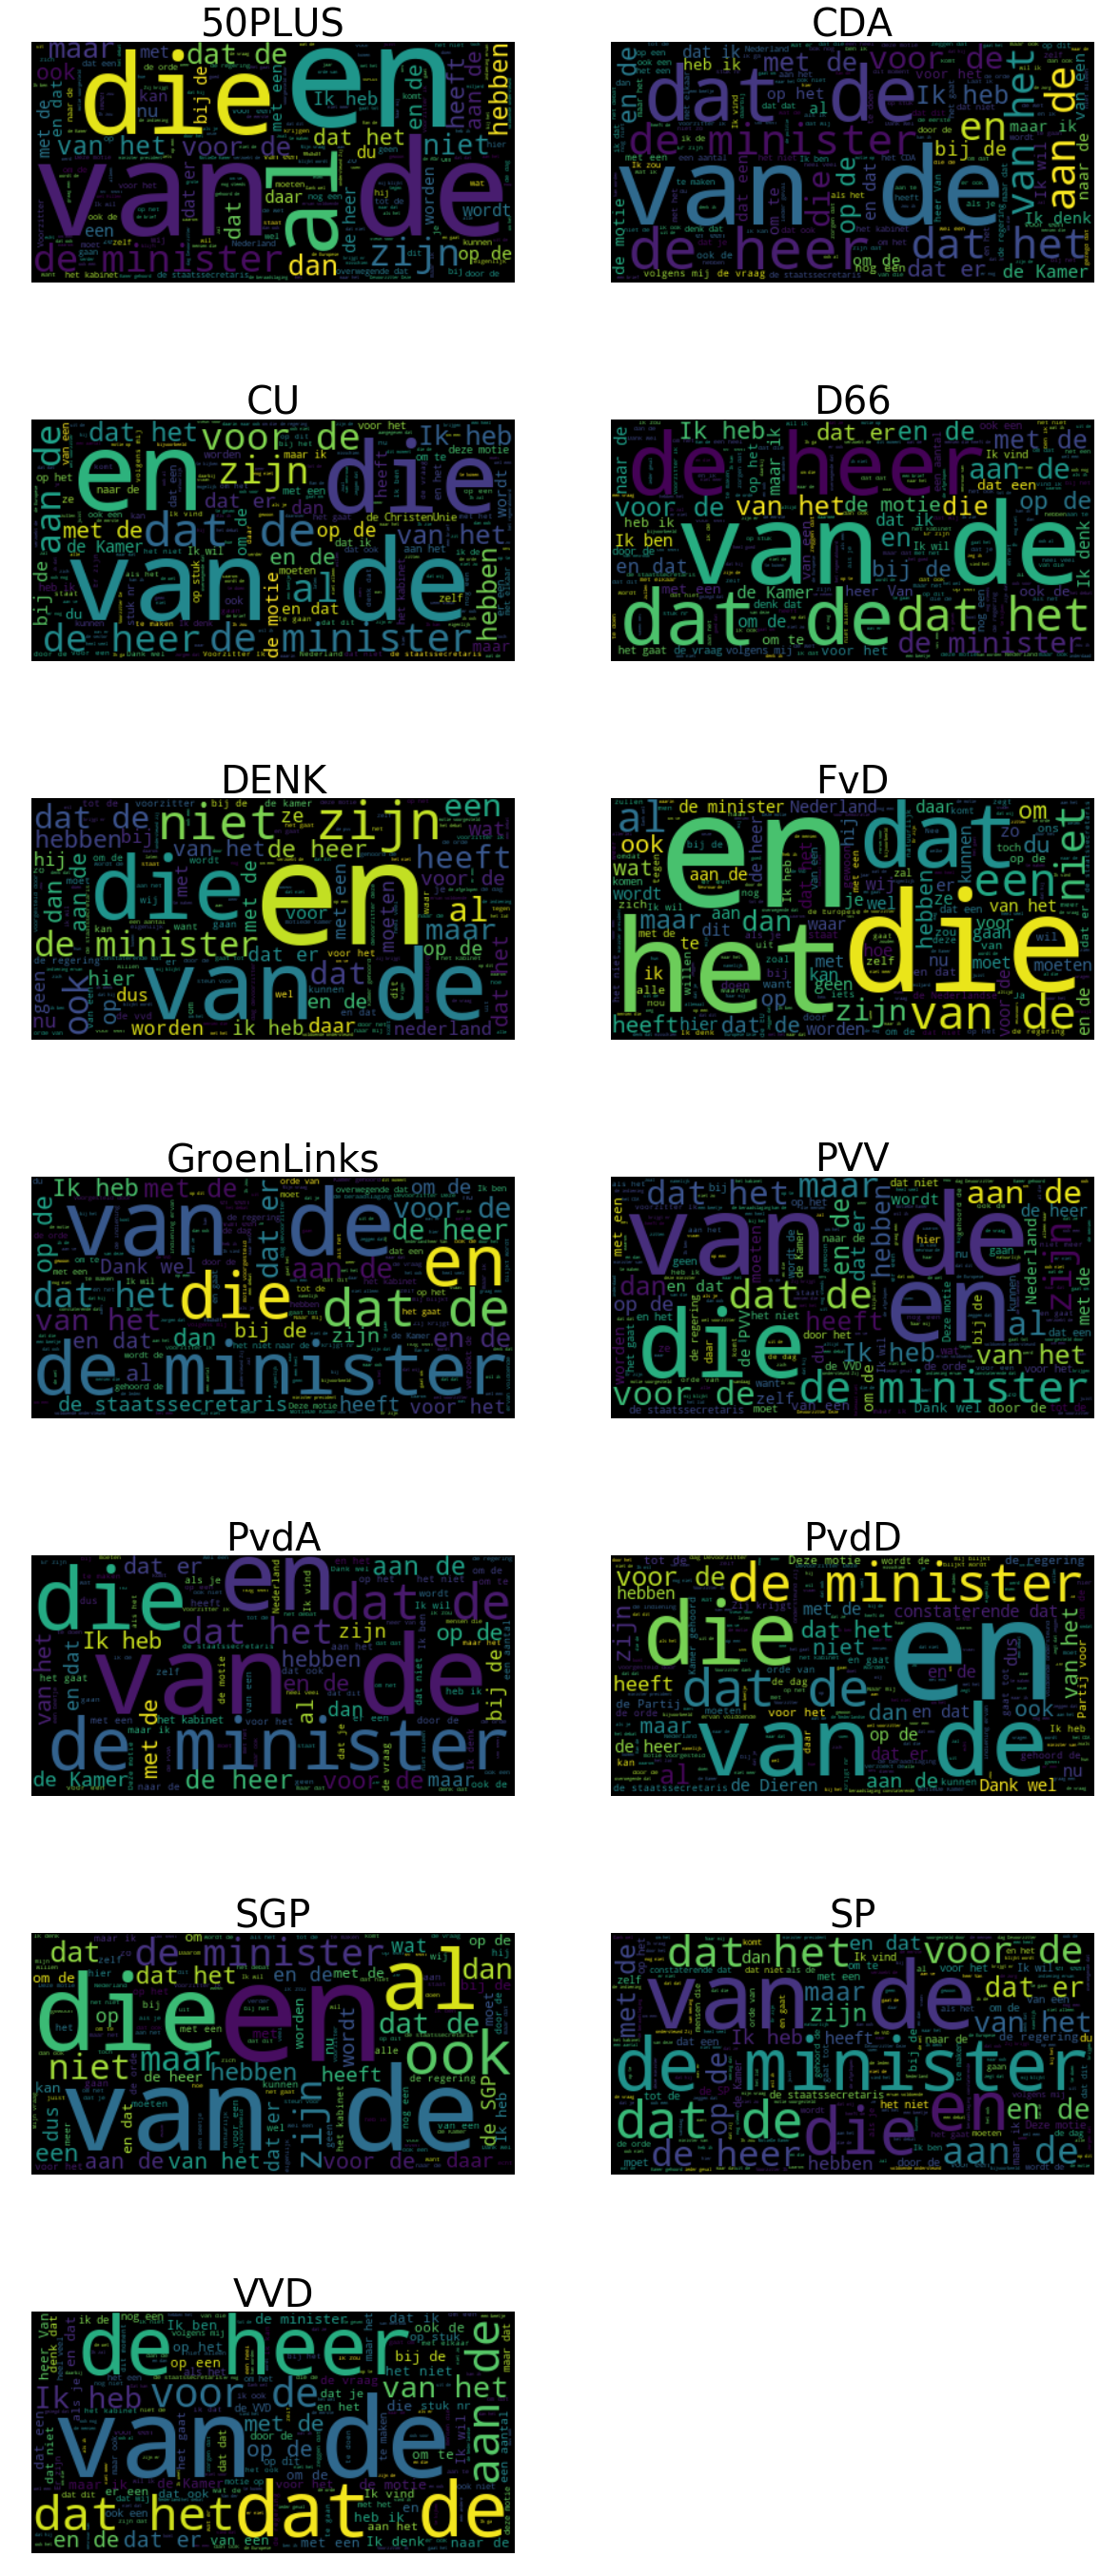

In [70]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from stop_words import get_stop_words
import nltk
    
plot = plt.figure(figsize=(20,50))

text = " ".join(spreekBeurt for spreekBeurt in VPL)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('50PLUS', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in CDA)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('CDA', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in CU)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('CU', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in D66)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,4)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('D66', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in DENK)
text = text.lower()
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('DENK', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in FvD)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,6)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('FvD', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in GL)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,7)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('GroenLinks', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PVV)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,8)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PVV', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PvdA)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,9)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PvdA', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PvdD)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,10)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PvdD', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in SGP)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,11)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('SGP', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in SP)
wordcloud = WordCloud().generate(text)

plt.subplot(7,2,12)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('SP', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in VVD)
wordcloud = WordCloud().generate(text)
b
plt.subplot(7,2,13)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('VVD', fontdict = {'fontsize': 40})

plt.show()

In [71]:
plot.savefig('graphraw.png')

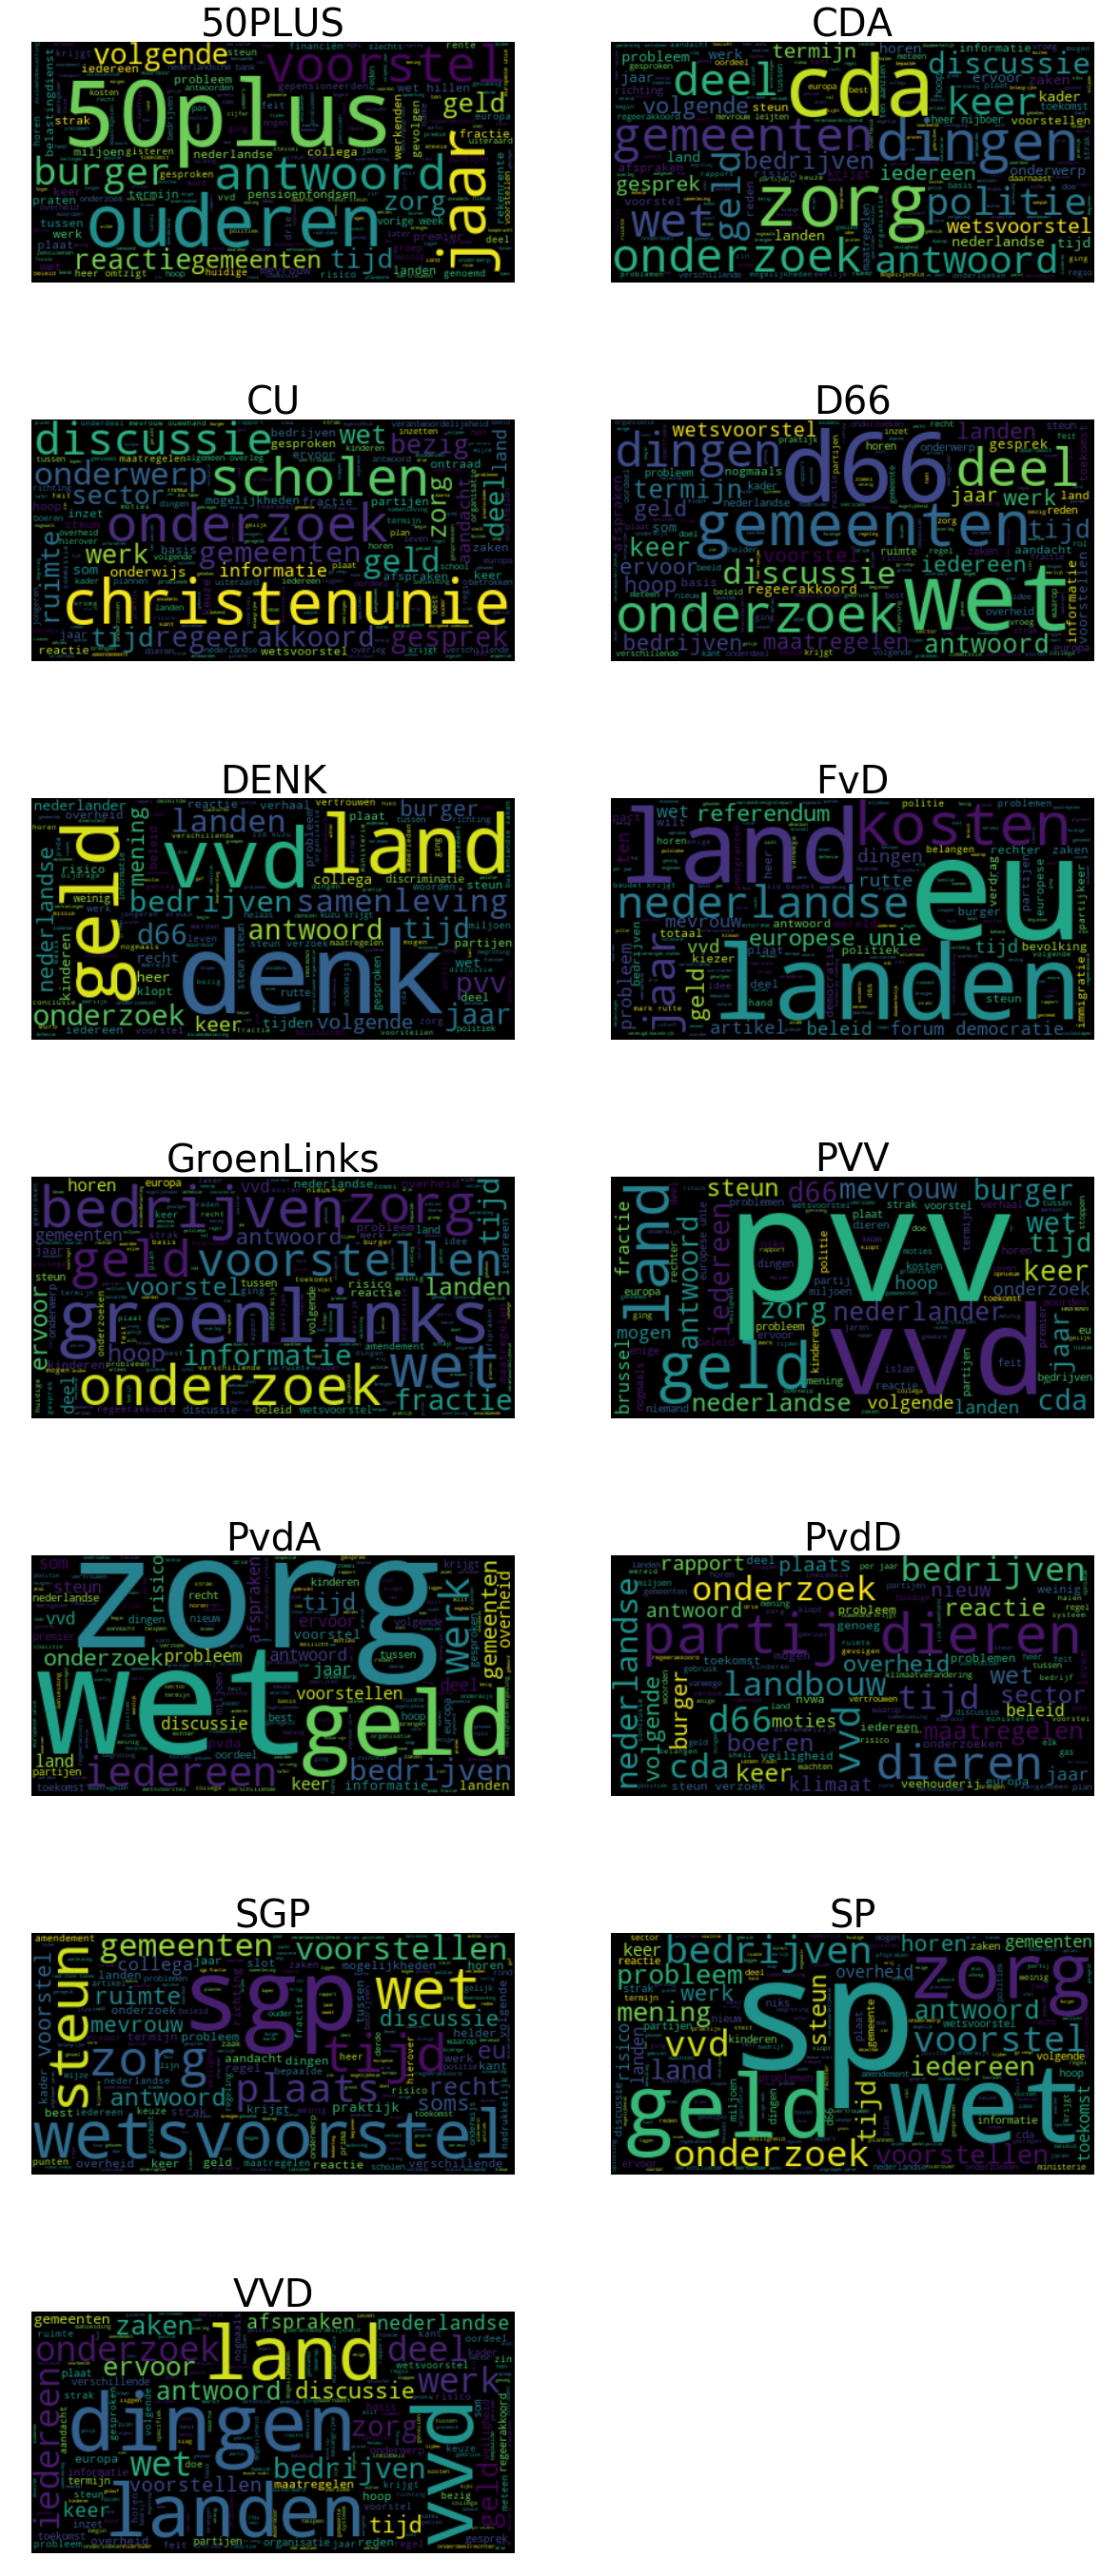

In [85]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from stop_words import get_stop_words
import nltk

stopwoorden = get_stop_words('dutch')
stopword_list = nltk.corpus.stopwords.words('dutch')
stopwoorden = stopwoorden + stopword_list
file = open('stopwoordenlijst.txt','r') 
for line in file: 
    stopwoorden.append(line) 
extras = ['we', 'wij','gaan','minister','gaat','wel','moeten','mensen','vraag',
          'nederland','voorzitter','waar','goed','kabinet','echt','willen','komen',
          'heel','zeggen','alleen', 'staatssecretaris', 'eigenlijk','zegt','komt',
          'vind','orde','dag','weer','motiede','maken','gehoorde beraadslaging',
         'zoals','namelijk','steeds','vragen','kijk','kijken','even','krijgen','zei',
         'gezegd','volgen','staat','waarom','president','miljard','kamer','zonder','ander',
         'moment','laten','zullen','volgen','volgens','inderdaad','overwegende','stuk','nr',
         'juist','net','verzoekt','regering','bijvoorbeeld','indiening ervan','nou','devoorzitter',
         'motie','beraadslaging constaterende','gehoord', 'beraadslaging','indiening ervan',
         'blijkt','indiening','voldoende ondersteund','ervan', 'voldoende','kunt','weet','ga',
         'constaterende','ondersteund','gewoon','natuurlijk','allemaal','alle','helemaal',
         'voorgesteld','mee','zodat','aangegeven','misschien','debat','zien','daarbij','gedaan',
         'weten','betreft','nodig','zouden','daarom','aantal','collega','af','belang','vaak',
         'zit','laat','graag','punt','vindt','zie','doet','onze','anders','geval','lijkt',
         'goede','toe','welke','allerlei','twee','situatie','vraagt','staan','zitten','terwijl',
         'brief','zeer','één','tweede','stellen','zo\'n','manier','beetje','blijft','daarmee',
         'dank','zelfs','vanuit','gebeurt','geven','vinden','overigens','zeg','vervolgen','belangrijk',
         'daarover','binnen','uiteindelijk','mag','ligt','beter','eerst','betekent','gegeven',
         'precies','voorkomen','geldt','daarin','blijven','verder','samen','soort','minder',
         'daarvan','duidelijk','erg','mogelijk','eerder','houden','eerder','waarin','zeker','nemen',
         'daarvoor','werken','eigen','nieuwe','gesteld','hadden','terecht','grote','hebt','ziet',
         'vandaag','gevraagd','groot','terug','elkaar','bijna','groot','bereid','vooral','extra',
         'lang','heer omtzigt','via','hele','eerste','ieder','maakt','waarbij','kom','geeft',
         'vervolgens','gebeuren','wanneer','snel','gezien','begrijp','gehad','gemaakt','sprake',
         'zorgen','zetten','nee','slecht','tegelijkertijd','laatste','kun','nooit','bent','weg',
         'betalen','stemmen','steunen','enzovoort','hoeveel','blij','mooi','proberen','enzovoorts',
         'hoor','voeren','spreken']
for extra in extras:
    stopwoorden.append(extra)
    
plot = plt.figure(figsize=(20,50))

text = " ".join(spreekBeurt for spreekBeurt in VPL)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('50PLUS', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in CDA)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('CDA', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in CU)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('CU', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in D66)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,4)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('D66', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in DENK)
text = text.lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('DENK', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in FvD)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,6)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('FvD', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in GL)
text = text.replace('denk','').lower()

wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,7)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('GroenLinks', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PVV)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,8)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PVV', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PvdA)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,9)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PvdA', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in PvdD)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,10)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('PvdD', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in SGP)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,11)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('SGP', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in SP)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,12)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('SP', fontdict = {'fontsize': 40})

text = " ".join(spreekBeurt for spreekBeurt in VVD)
text = text.replace('denk','').lower()
wordcloud = WordCloud(stopwords=stopwoorden).generate(text)

plt.subplot(7,2,13)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('VVD', fontdict = {'fontsize': 40})

plt.show()

In [87]:
plot.savefig('graphnoun.png')

We willen ook onderzoeken een stemmer toevoegen, op die manier worden vervoegingen van woorden als hetzelfde woord meegeteld en we verwachten dat dit ons model beter zal laten presteren. 

In [12]:
# stemmer
stemmer = DutchStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

Hieronder hebben we een pijplijn gebouwd om te classificeren. 
Aan deze pijplijn hebben we toegevoegd:
- een countvectorizer die telt hoe vaak woorden voorkomen in een tekst. Hieraan hebben we een stemmer toegevoegd die ervoor zorgd dat vervoegingen van woorden als één woord worden meegeteld. Verder hebben we opgegeven of er gegeken moet worden per woord, of dat ook combinaties van woorden bekeken moeten worden. We hebben getest welk aantal woorden het best werkt en hieruit bleek dat het geen toegevoegde waarde heeft om voor meerdere woorden te kijken, dus ngram_range = (1,1). Verder wilden we ook de stopwoorden verwijderen. Omdat we in eerste instantie niet een goede Nederlandse stopwoordenlijst konden vinden, hebben we ervoor gekozen om gebruik te maken van de max_df parameter die volgens de documentatie tussen de 0,7 en 1 gezet kon worden om automatisch stopwoorden te detecteren. 
- We hebben een TfidfTransformer toegevoegd om de juiste woorden belangrijker te maken.
- Daarna hebben we een model toegevoegd. Hieronder hebben we voor verschillende modellen getest waar de hoogste accuracy is behaald.

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

# accuracy score: 0.20542565676627245

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

# Accuracy score: 0.4075110589509795

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

# Accuracy score 0.4043062200956938

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

# duurt te lang om te runnen

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', PassiveAggressiveClassifier())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

#Accuracy score: 0.3936535162950257

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

#Accuracy score: 0.13099214588787578

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', AdaBoostClassifier())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

# Accuracy score: 0.252098943757335

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

# Accuracy score: 0.23431434503927057

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

# Accuracy score: 0.22808522163040534

Het best scorende model is de SDG classifier en logistic regression. We zullen nu (een deel) van de parameters proberen te optimaliseren, om het uiteindelijke model te bepalen. We hebben nu ook een andere manier gevonden om stopwoorden te verwijderen, namelijk met een lijst. We zullen eerst de parameters optimaliseren met een stopwoordenlijst en daarna nog een keer een optimalisatie maar dan door max_df op verschillende waarden te zetten.

In [ ]:
from stop_words import get_stop_words
stopwoorden = get_stop_words('dutch')

In [ ]:
# bepalen parameters SDG classifier met stopwoorden verwijderen door hoeveel ze voorkomen in het document
max_df_param = 0.7
loss_param = "log"
penalty_param = "l2"

pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = max_df_param)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss=loss_param, penalty = penalty_param))])

for max_df_param in [0.7,0.85,1]:
    for loss_param in ["hinge","log"]:
        for penalty_param in ["l2","l1","elasticnet"]:
            pipeline.fit(X_train,Y_train)
            predicted = pipeline.predict(X_test)
            print(max_df_param, loss_param, penalty_param, accuracy_score(predicted,Y_test))

In [ ]:
# bepalen parameters SDG classifier met stopwoordenlijst
loss_param = "log"
penalty_param = "l2"

pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), stop_words = stopwoorden)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss=loss_param, penalty = penalty_param))])

for loss_param in ["hinge","log"]:
    for penalty_param in ["l2","l1","elasticnet"]:
        pipeline.fit(X_train,Y_train)
        predicted = pipeline.predict(X_test)
        print(max_df_param, loss_param, penalty_param, accuracy_score(predicted,Y_test))

Het blijkt dat de aangepaste versies van de modellen niet zo goed werken. De accuracy scores liggen namelijk net iets boven de 30%, terwijl het oorspronkelijke model rond de 40% zat. Waarschijnlijk heb ik dus niet de juiste parameters verandert. Daarom blijft het beste model alsnog het SDG model waarbij verder geen parameters zijn gespecificeerd. Hieronder is het beste model weergegeven. Het bleek dat de max_df aangeven bij dit model beter werkte dan de stopwoordenlijst, dus daarom is in het beste model de max_df gebruikt.

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])
     
t = time.time()
pipeline.fit(X_train,Y_train)
predicted = pipeline.predict(X_test)
print(accuracy_score(predicted,Y_test))
print(time.time() - t)

# Accuracy score: 0.4098582648731606

In [15]:
pipeline_lr = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearRegression())])

Y_train_lr = []
Y_test_lr = []
lr_dict = {0: -0.4,
          1:0.4,
          2:0,
          3:-0.3,
          4:-0.7,
          5:0.8,
          6:-1,
          7:0.2,
          8:-0.8,
          9:-1,
          10:0,
          11:-0.7,
          12:0.5}

for party in Y_train:
    Y_train_lr.append(lr_dict[party])

for party in Y_test:
    Y_test_lr.append(lr_dict[party])
    
t = time.time()
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
pipeline_lr.fit(X_train,Y_train_lr)
predicted_lr = pipeline_lr.predict(X_test)
print(mean_squared_error(predicted_lr,Y_test_lr))
print(time.time() - t)

2019-07-17 09:30:53
1.368663157694966
648.658310174942


In [16]:
pipeline_pc = Pipeline([
    ('vect', CountVectorizer(analyzer = stemmed_words, ngram_range=(1,1), max_df = 0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearRegression())])

Y_train_pc = []
Y_test_pc = []
pc_dict = {0: 0.2,
          1:-0.3,
          2:-0.1,
          3:1,
          4:0.6,
          5:-0.8,
          6:0.8,
          7:-0.9,
          8:0.5,
          9:0.3,
          10:-0.1,
          11:0.1,
          12:-0.5}

for party in Y_train:
    Y_train_pc.append(pc_dict[party])

for party in Y_test:
    Y_test_pc.append(pc_dict[party])
    
t = time.time()
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()))
pipeline_pc.fit(X_train,Y_train_pc)
predicted_pc = pipeline_pc.predict(X_test)
print(mean_squared_error(predicted_pc,Y_test_pc))
print(time.time() - t)

2019-07-17 09:41:42
1.4878738303630807
595.5488698482513


In [17]:
predicted = pd.DataFrame({'party': Y_test, 'left/right' : predicted_lr, 'pro/con' : predicted_pc})

In [32]:
predicted.head()

predicted = predicted[predicted['left/right'] < 1]
predicted = predicted[predicted['left/right'] > -1]
predicted = predicted[predicted['pro/con'] < 1]
predicted = predicted[predicted['pro/con'] > -1]

([], <a list of 0 Text yticklabel objects>)

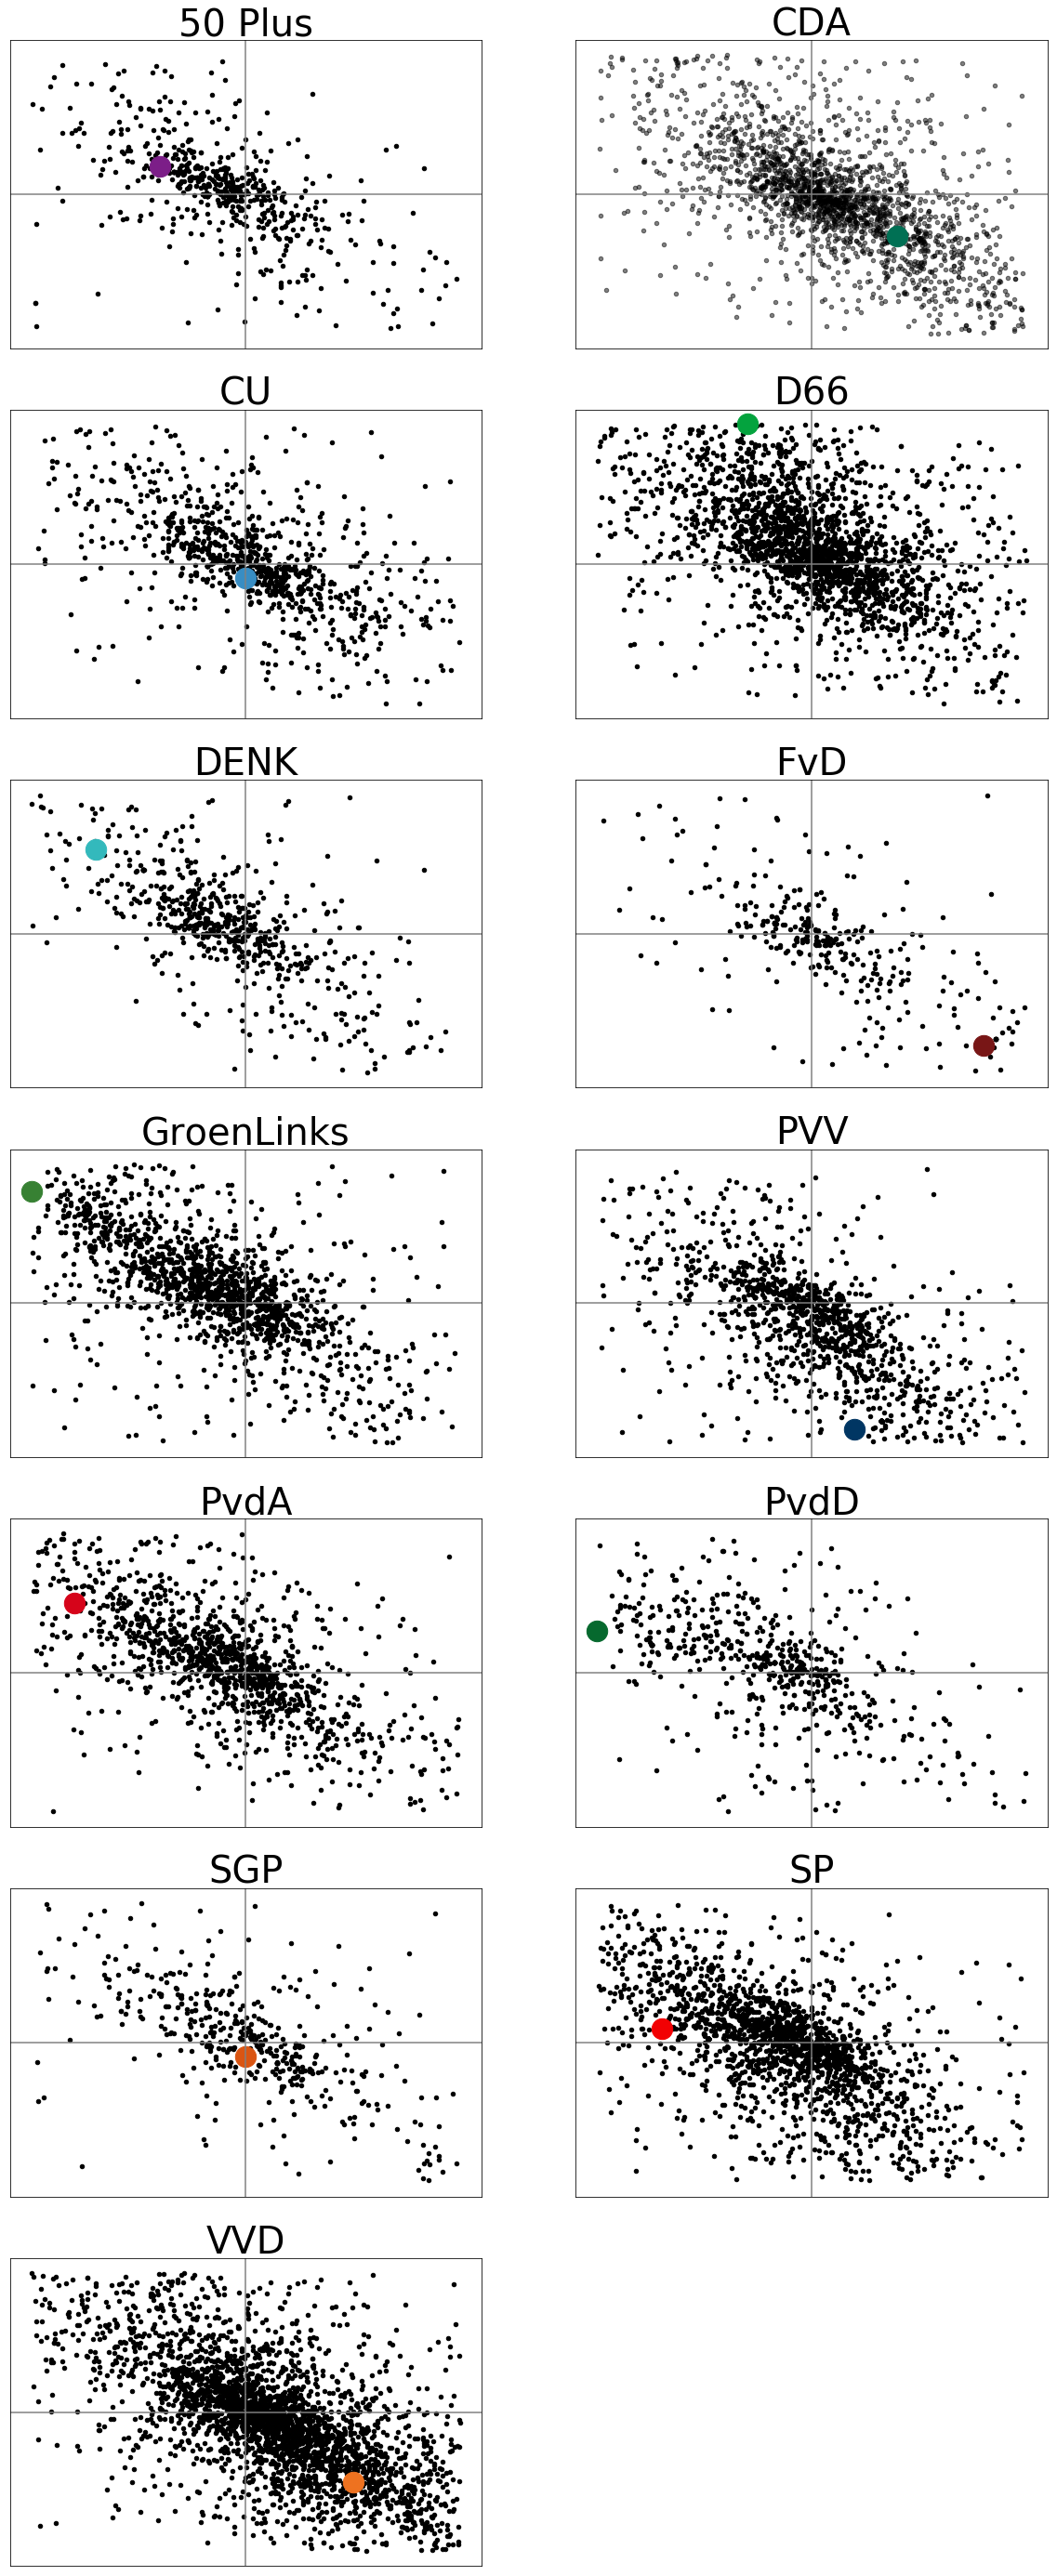

In [56]:
plot = plt.figure(figsize=(20,50))

plt.subplot(7,2,1)
plt.scatter(predicted[predicted['party'] == 0]['left/right'], predicted[predicted['party'] == 0]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[0],pc_dict[0], s = 500, c = [[124/255,30/255,136/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('50 Plus', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,2)
plt.scatter(predicted[predicted['party'] == 1]['left/right'], predicted[predicted['party'] == 1]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[1],pc_dict[1], s = 500, c = [[0/255,112/255,84/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('CDA', fontdict = {'fontsize': 40})
plt.xticks([])
p = plt.yticks([])

plt.subplot(7,2,3)
p = 2

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[56/255,141/255,195/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('CU', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,4)

p = 3

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[4/255,163/255,62/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('D66', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,5)

p = 4

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[51/255,185/255,188/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('DENK', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,6)

p = 5

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[120/255,22/255,22/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('FvD', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,7)

p = 6

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[55/255,129/255,51/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('GroenLinks', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,8)

p = 7

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[0/255,54/255,99/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('PVV', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,9)

p = 8

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[214/255,4/255,26/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('PvdA', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,10)

p = 9

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[6/255,105/255,46/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('PvdD', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,11)

p = 10

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[218/255,85/255,18/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('SGP', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,12)

p = 11

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[242/255,1/255,3/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('SP', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

plt.subplot(7,2,13)

p = 12

plt.scatter(predicted[predicted['party'] == p]['left/right'], predicted[predicted['party'] == p]['pro/con'],
            c = [[0,0,0]],s = 20)
plt.scatter(lr_dict[p],pc_dict[p], s = 500, c = [[238/255,114/255,32/255]])
plt.plot([-10,10],[0,0], c = 'gray')
plt.plot([0,0],[-10,10], c = 'gray')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title('VVD', fontdict = {'fontsize': 40})
plt.xticks([])
plt.yticks([])

In [54]:
plot.savefig('graph4.png')

50PLUS 0
CDA 1
CU 2
D66 3
DENK 4
FvD 5
GroenLinks 6
PVV 7
PvdA 8
PvdD 9
SGP 10
SP 11
VVD 12